In [78]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))

466
156


In [79]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [80]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [81]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
        
def rearrange(p, idcs):
    return p[:,idcs][idcs]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [82]:
# Calculate pearson matrices

train_rest_p = np.stack([rearrange(np.corrcoef(sub), revMap2) for sub in train_rest_ts])
test_rest_p = np.stack([rearrange(np.corrcoef(sub), revMap2) for sub in test_rest_ts])

train_nback_p = np.stack([rearrange(np.corrcoef(sub), revMap2) for sub in train_nback_ts])
test_nback_p = np.stack([rearrange(np.corrcoef(sub), revMap2) for sub in test_nback_ts])

print(train_rest_p[0].shape)
print('Complete')

(264, 264)
Complete


In [83]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [84]:
# Convert to torch

import torch

train_rest_p_torch = torch.from_numpy(train_rest_p).float()
train_nback_p_torch = torch.from_numpy(train_nback_p).float()

test_rest_p_torch = torch.from_numpy(test_rest_p).float()
test_nback_p_torch = torch.from_numpy(test_nback_p).float()

X_train_torch = torch.from_numpy(X_train).float()
X_test_torch = torch.from_numpy(X_test).float()

print(test_rest_p_torch.shape)
print('Complete')

torch.Size([156, 264, 264])
Complete


In [85]:
import torch

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.abs(torch.sum(A,dim=1))**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdgesCosine(ps1, ps2, regions):
    stk = []
    for i in range(len(regions)-1):
        r1s = regions[i]
        r1e = regions[i+1]
        for j in range(i,len(regions)-1):
            r2s = regions[j]
            r2e = regions[j+1]
            ps1r = ps1[:,r1s:r1e,r2s:r2e]
            ps2r = ps2[:,r1s:r1e,r2s:r2e]
            e = torch.einsum('aij,bij->ab',ps1r,ps2r)
            ps1rn = torch.einsum('aij,aij->a',ps1r,ps1r)
            ps2rn = torch.einsum('aij,aij->a',ps2r,ps2r)
            e /= ps1rn.unsqueeze(1)
            e /= ps2rn.unsqueeze(1).T
            stk.append(e)
#             stk.append(normalize(e))
    e = torch.stack(stk, dim=2)
    return e

# Euclidean distance
def calcEdgesEuclidean(ps1, ps2, regions):
    N1 = ps1.shape[0]
    N2 = ps2.shape[0]
    stk = []
    for i in range(len(regions)-1):
        r1s = regions[i]
        r1e = regions[i+1]
        for j in range(i,len(regions)-1):
            r2s = regions[j]
            r2e = regions[j+1]
            ps1r = ps1[:,r1s:r1e,r2s:r2e]
            ps2r = ps2[:,r1s:r1e,r2s:r2e]
            ps1rv = ps1r.reshape(N1,-1)
            ps2rv = ps2r.reshape(N2,-1)
            e = torch.cdist(ps1rv, ps2rv)
#             m = torch.max(e)
            stk.append(e)
#             stk.append(normalize(m-e))
    e = torch.stack(stk, dim=2)
    return e
    
def setTestEdgesOnTrain(e, eTest, eTestTest):
    et = torch.zeros(e.shape[0]+1, e.shape[1]+1, e.shape[2])
    et[:-1,:-1,:] = e
    et[:-1,-1,:] = eTest.squeeze()
    et[-1,:-1,:] = eTest.squeeze()
    et[-1,-1,:] = eTestTest.squeeze()
    return et

def setTestEdgesOnTest(e, eTest, eTestTest):
    e[:-1,-1,:] = eTest.squeeze()
    e[-1,:-1,:] = eTest.squeeze()
    e[-1,-1,:] = eTestTest.squeeze()
    return et
    
print('Complete')

Complete


In [62]:
e = calcEdgesEuclidean(train_rest_p_torch, train_rest_p_torch, borders1)
et1 = calcEdgesEuclidean(train_rest_p_torch, test_rest_p_torch[0:1], borders1)
# et2 = calcEdgesCosine(test_rest_p_torch[0:1], test_rest_p_torch[0:1], borders1)
# et = setTestEdgesOnTrain(e, et1, et2)

print(e.shape)
print(et1.shape)
print('Complete')

torch.Size([466, 466, 105])
torch.Size([466, 1, 105])
Complete


In [70]:
# Least squares on 105 edges

# lam = 1
# A = torch.cat([e.reshape(e.shape[0],-1), torch.ones(e.shape[0],1)], dim=1)
A = e.reshape(e.shape[0],-1)
B = X_train_torch[:,0]

print(A.shape)
print(B.shape)

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([466, 48930])
torch.Size([466])
torch.Size([48930, 1])
tensor(0.0321)
tensor(2.0222e-08)
tensor(0.0003)


In [41]:
print(e.shape)

torch.Size([466, 466, 105])


In [71]:
# Find accuracy on test set

et = calcEdgesEuclidean(test_rest_p_torch, train_rest_p_torch, borders1)
print(et.shape)

etr = et.reshape(et.shape[0], -1)
print('Finished edges')

pred = (etr@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/etr.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

torch.Size([156, 466, 105])
Finished edges
Finished
tensor(2.8516)
tensor(2.2791)


[[1.         0.47235185]
 [0.47235185 1.        ]]
2.8515604571569
2.279117942875267


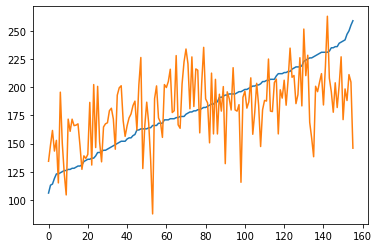

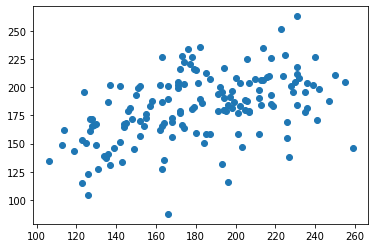

In [72]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test_torch[:,0]).numpy()
yPred = pred[idcs].numpy()
y = X_test_torch[:,0][idcs].numpy()

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [66]:
A = train_rest_p_torch.reshape(train_rest_p_torch.shape[0], -1)
B = X_train_torch[:,0]

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([69696, 1])
tensor(0.0558)
tensor(3.6519e-07)
tensor(0.0014)


In [67]:
# Find accuracy on test set

test = test_rest_p_torch.reshape(test_rest_p_torch.shape[0], -1)
pred = (test@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/test.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

Finished
tensor(2.7601)
tensor(2.1854)


[[1.        0.5025795]
 [0.5025795 1.       ]]
2.7600701786252846
2.1853882879273505


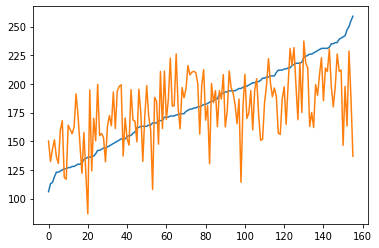

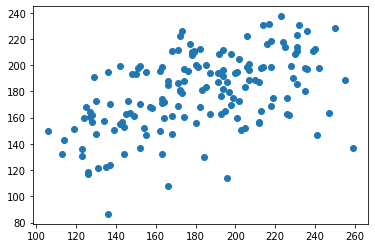

In [68]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test_torch[:,0]).numpy()
yPred = pred[idcs].numpy()
y = X_test_torch[:,0][idcs].numpy()

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [74]:
A1 = e.reshape(e.shape[0],-1)
A2 = train_rest_p_torch.reshape(train_rest_p_torch.shape[0], -1)
A = torch.cat([A1, A2], dim=1)
B = X_train_torch[:,0]

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([118626, 1])
tensor(0.0172)
tensor(8.8519e-07)
tensor(0.0023)


In [75]:
# Find accuracy on test set

test1 = etr
test2 = test_rest_p_torch.reshape(test_rest_p_torch.shape[0], -1)
test = torch.cat([test1, test2], dim=1)
pred = (test@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/test.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

Finished
tensor(2.7909)
tensor(2.2292)


[[1.         0.48850514]
 [0.48850514 1.        ]]
2.7908754878519786
2.2291624933226495


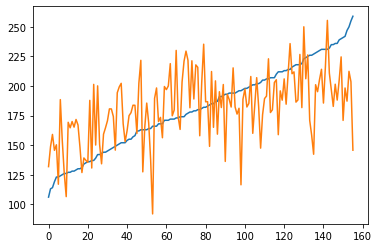

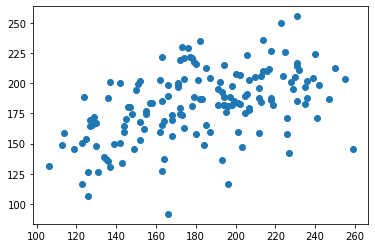

In [76]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test_torch[:,0]).numpy()
yPred = pred[idcs].numpy()
y = X_test_torch[:,0][idcs].numpy()

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [86]:
err = calcEdgesEuclidean(train_rest_p_torch, train_rest_p_torch, borders1)
ern = calcEdgesEuclidean(train_rest_p_torch, train_nback_p_torch, borders1)
enn = calcEdgesEuclidean(train_nback_p_torch, train_nback_p_torch, borders1)

print(err.shape)
print(ern.shape)
print(enn.shape)

torch.Size([466, 466, 105])
torch.Size([466, 466, 105])
torch.Size([466, 466, 105])


In [88]:
e = torch.cat([err, ern, enn], dim=1)
A = e.reshape(e.shape[0], -1)
B = X_train_torch[:,0]

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([146790, 1])
tensor(0.0106)
tensor(1.1573e-07)
tensor(0.0007)


In [89]:
# Find accuracy on test set

# et = calcEdgesEuclidean(test_rest_p_torch, train_rest_p_torch, borders1)
etrr = calcEdgesEuclidean(test_rest_p_torch, train_rest_p_torch, borders1)
etrn = calcEdgesEuclidean(test_rest_p_torch, train_nback_p_torch, borders1)
etnn = calcEdgesEuclidean(test_nback_p_torch, train_nback_p_torch, borders1)
et = torch.cat([etrr, etrn, etnn], dim=1)

At = et.reshape(et.shape[0], -1)
print('Finished edges')

pred = (At@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/At.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

Finished edges
Finished
tensor(2.6444)
tensor(2.1130)


[[1.         0.56139854]
 [0.56139854 1.        ]]
2.6443578584131044
2.1130444127270303


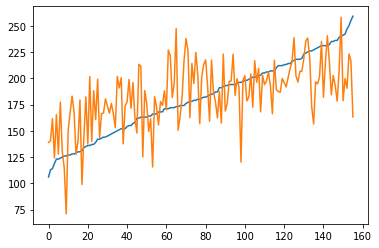

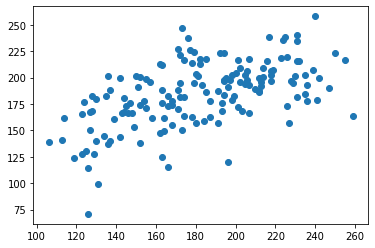

In [90]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test_torch[:,0]).numpy()
yPred = pred[idcs].numpy()
y = X_test_torch[:,0][idcs].numpy()

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [91]:
A = train_nback_p_torch.reshape(train_nback_p_torch.shape[0], -1)
B = X_train_torch[:,0]

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([69696, 1])
tensor(0.0670)
tensor(9.1547e-08)
tensor(0.0006)


In [92]:
# Find accuracy on test set

test = test_nback_p_torch.reshape(test_nback_p_torch.shape[0], -1)
pred = (test@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/test.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

Finished
tensor(2.3878)
tensor(1.9002)


In [95]:
A = enn.reshape(enn.shape[0], -1)
B = X_train_torch[:,0]

w, _ = torch.lstsq(B,A)

print(w.shape)
print(torch.mean(torch.abs(w)))

res = (A@w).flatten() - B

print(torch.sum((res/12)**2)/e.shape[0]**0.5)
print(torch.mean(torch.abs(res)))

torch.Size([48930, 1])
tensor(0.0392)
tensor(1.8205e-07)
tensor(0.0010)


In [96]:
At = etnn.reshape(etnn.shape[0], -1)
print('Finished edges')

pred = (At@w).flatten()
    
print('Finished')

res = pred - X_test_torch[:,0]
print((torch.sum(res**2)/At.shape[0])**0.5/12)
print(torch.mean(torch.abs(res/12)))

Finished edges
Finished
tensor(2.4650)
tensor(2.0087)


In [100]:
a = 264*264*264
b = a*446
print(a)
print(b)

18399744
8206285824


In [102]:
print(train_rest_ts[0].shape)
train_rest_ts_all = torch.from_numpy(np.stack([sub for sub in train_rest_ts]))
test_rest_ts_all = torch.from_numpy(np.stack([sub for sub in test_rest_ts]))
print(train_rest_ts_all.shape)

(264, 124)
torch.Size([466, 264, 124])


In [104]:
xyz = torch.einsum('nat,nbt,nct->nabc', train_rest_ts_all, train_rest_ts_all, train_rest_ts_all)
print('Complete')

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 68594245632 bytes. Buy new RAM!